In [1]:
import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.initializers import glorot_uniform
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import pandas as pd
%matplotlib inline

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

C:\Users\20190\anaconda3\lib\site-packages\keras\backend.py:414: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


In [2]:
final_df = pd.read_csv(r'C:\Users\20190\Downloads\final_train.csv')
X = final_df.drop(columns = ['emotion'])
X.head()
X = X.to_numpy()
x_temp = np.reshape(X,(28709,48,48,1))
x_temp = x_temp/255
y = final_df['emotion']
y = y.to_numpy()
b = np.zeros((y.size, y.max()+1))
b[np.arange(y.size),y] = 1
validation_data,validation_label = x_temp[:2870],b[:2870]
train_data,train_label = x_temp[2870:],b[2870:]

In [3]:
def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block as defined in Figure 3
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)
    

    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X,X_shortcut])
    X = Activation("relu")(X)
    
    
    return X

In [4]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    

    # Second component of main path (≈3 lines)
    X = Conv2D(F2, (f, f), strides = (1,1),padding = "same", name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(F3, (1, 1), strides = (1,1), name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)
    
    X_shortcut = Conv2D(F3, (1, 1), strides = (s,s), name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)
    
    
    return X

In [5]:
def ResNet50(input_shape = (48, 48, 1), classes = 7):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [48, 48, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [48, 48, 256], stage=2, block='b')
    X = identity_block(X, 3, [48, 48, 256], stage=2, block='c')

    ### START CODE HERE ###

    # Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D(pool_size=(2,2),name = "avg_pool")(X)
    
    ### END CODE HERE ###

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [6]:
model = ResNet50(input_shape = (48, 48, 1), classes = 5)

In [7]:
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [7]:
from keras.preprocessing.image import ImageDataGenerator
train_data_dir = 'train'
validation_data_dir = 'validation'
img_rows = 48
img_cols = 48
batch_size = 32
num_classes = 5

train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=30,
                    shear_range=0.3,
                    zoom_range=0.3,
                    width_shift_range=0.4,
                    height_shift_range=0.4,
                    horizontal_flip=True,
                    fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
                    train_data_dir,
                    color_mode='grayscale',
                    target_size=(48,48),
                    batch_size=batch_size,
                    class_mode='categorical',
                    shuffle=True)

validation_generator = validation_datagen.flow_from_directory(
                        validation_data_dir,
                        color_mode='grayscale',
                        target_size=(img_rows,img_cols),
                        batch_size=batch_size,
                        class_mode='categorical',
                        shuffle=True)

from tensorflow.keras.optimizers import RMSprop,SGD,Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint('resnet_adam.h5',
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True,
                             verbose=1)

callbacks = [checkpoint]

model.compile(loss='categorical_crossentropy',
              optimizer = Adam(lr=0.001),
              metrics=['accuracy'])

nb_train_samples = 24176
nb_validation_samples = 3006
epochs=50

history_adam=model.fit_generator(
                train_generator,
                steps_per_epoch=nb_train_samples//batch_size,
                epochs=epochs,
                callbacks=callbacks,
                validation_data=validation_generator,
                validation_steps=nb_validation_samples//batch_size)

Found 24282 images belonging to 5 classes.
Found 5937 images belonging to 5 classes.


C:\Users\20190\anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
C:\Users\20190\AppData\Local\Temp/ipykernel_3528/1150654139.py:56: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_adam=model.fit_generator(


Epoch 1/50
754/755 [============================>.] - ETA: 0s - loss: 1.9552 - accuracy: 0.2677
Epoch 00001: val_loss improved from inf to 1.53487, saving model to resnet_adam.h5


C:\Users\20190\anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


755/755 [==============================] - 38s 39ms/step - loss: 1.9546 - accuracy: 0.2678 - val_loss: 1.5349 - val_accuracy: 0.3128
Epoch 2/50
755/755 [==============================] - ETA: 0s - loss: 1.6390 - accuracy: 0.2913
Epoch 00002: val_loss improved from 1.53487 to 1.51802, saving model to resnet_adam.h5
755/755 [==============================] - 24s 32ms/step - loss: 1.6390 - accuracy: 0.2913 - val_loss: 1.5180 - val_accuracy: 0.3317
Epoch 3/50
754/755 [============================>.] - ETA: 0s - loss: 1.5633 - accuracy: 0.3115
Epoch 00003: val_loss improved from 1.51802 to 1.48987, saving model to resnet_adam.h5
755/755 [==============================] - 23s 31ms/step - loss: 1.5633 - accuracy: 0.3117 - val_loss: 1.4899 - val_accuracy: 0.3501
Epoch 4/50
754/755 [============================>.] - ETA: 0s - loss: 1.5342 - accuracy: 0.3285
Epoch 00004: val_loss improved from 1.48987 to 1.43205, saving model to resnet_adam.h5
755/755 [==============================] - 23s 31ms/

Epoch 29/50
755/755 [==============================] - ETA: 0s - loss: 1.0166 - accuracy: 0.5977
Epoch 00029: val_loss did not improve from 0.84998
755/755 [==============================] - 71s 94ms/step - loss: 1.0166 - accuracy: 0.5977 - val_loss: 1.0564 - val_accuracy: 0.5743
Epoch 30/50
755/755 [==============================] - ETA: 0s - loss: 1.0090 - accuracy: 0.6010
Epoch 00030: val_loss improved from 0.84998 to 0.82773, saving model to resnet_adam.h5
755/755 [==============================] - 95s 126ms/step - loss: 1.0090 - accuracy: 0.6010 - val_loss: 0.8277 - val_accuracy: 0.6821
Epoch 31/50
755/755 [==============================] - ETA: 0s - loss: 1.0020 - accuracy: 0.5981
Epoch 00031: val_loss did not improve from 0.82773
755/755 [==============================] - 95s 125ms/step - loss: 1.0020 - accuracy: 0.5981 - val_loss: 0.8734 - val_accuracy: 0.6626
Epoch 32/50
753/755 [============================>.] - ETA: 0s - loss: 0.9878 - accuracy: 0.6031
Epoch 00032: val_loss 

In [8]:
model = ResNet50(input_shape = (48, 48, 1), classes = 5)
from keras.preprocessing.image import ImageDataGenerator
train_data_dir = 'train'
validation_data_dir = 'validation'
img_rows = 48
img_cols = 48
batch_size = 32
num_classes = 5

train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=30,
                    shear_range=0.3,
                    zoom_range=0.3,
                    width_shift_range=0.4,
                    height_shift_range=0.4,
                    horizontal_flip=True,
                    fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
                    train_data_dir,
                    color_mode='grayscale',
                    target_size=(48,48),
                    batch_size=batch_size,
                    class_mode='categorical',
                    shuffle=True)

validation_generator = validation_datagen.flow_from_directory(
                        validation_data_dir,
                        color_mode='grayscale',
                        target_size=(img_rows,img_cols),
                        batch_size=batch_size,
                        class_mode='categorical',
                        shuffle=True)

from tensorflow.keras.optimizers import RMSprop,SGD,Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint('resnet_rmsprop.h5',
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True,
                             verbose=1)

callbacks = [checkpoint]

model.compile(loss='categorical_crossentropy',
              optimizer = RMSprop(),
              metrics=['accuracy'])

nb_train_samples = 24176
nb_validation_samples = 3006
epochs=50

history_rmsprop=model.fit_generator(
                train_generator,
                steps_per_epoch=nb_train_samples//batch_size,
                epochs=epochs,
                callbacks=callbacks,
                validation_data=validation_generator,
                validation_steps=nb_validation_samples//batch_size)

Found 24282 images belonging to 5 classes.
Found 5937 images belonging to 5 classes.
Epoch 1/50


C:\Users\20190\AppData\Local\Temp/ipykernel_3528/1984021645.py:57: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_rmsprop=model.fit_generator(


755/755 [==============================] - ETA: 0s - loss: 2.0880 - accuracy: 0.2727
Epoch 00001: val_loss improved from inf to 4.09558, saving model to resnet_rmsprop.h5
755/755 [==============================] - 28s 33ms/step - loss: 2.0880 - accuracy: 0.2727 - val_loss: 4.0956 - val_accuracy: 0.2745
Epoch 2/50
755/755 [==============================] - ETA: 0s - loss: 1.6210 - accuracy: 0.2915
Epoch 00002: val_loss improved from 4.09558 to 2.29213, saving model to resnet_rmsprop.h5
755/755 [==============================] - 25s 33ms/step - loss: 1.6210 - accuracy: 0.2915 - val_loss: 2.2921 - val_accuracy: 0.1754
Epoch 3/50
755/755 [==============================] - ETA: 0s - loss: 1.5557 - accuracy: 0.3077
Epoch 00003: val_loss improved from 2.29213 to 1.56782, saving model to resnet_rmsprop.h5
755/755 [==============================] - 26s 34ms/step - loss: 1.5557 - accuracy: 0.3077 - val_loss: 1.5678 - val_accuracy: 0.3044
Epoch 4/50
755/755 [==============================] - ETA:

754/755 [============================>.] - ETA: 0s - loss: 1.0734 - accuracy: 0.5725 ETA: 
Epoch 00028: val_loss did not improve from 0.93688
755/755 [==============================] - 25s 34ms/step - loss: 1.0732 - accuracy: 0.5727 - val_loss: 1.0023 - val_accuracy: 0.6233
Epoch 29/50
755/755 [==============================] - ETA: 0s - loss: 1.0628 - accuracy: 0.5744
Epoch 00029: val_loss did not improve from 0.93688
755/755 [==============================] - 25s 34ms/step - loss: 1.0628 - accuracy: 0.5744 - val_loss: 0.9970 - val_accuracy: 0.5971
Epoch 30/50
754/755 [============================>.] - ETA: 0s - loss: 1.0560 - accuracy: 0.5799 ETA: 0s - loss: 1.0564 - accuracy
Epoch 00030: val_loss did not improve from 0.93688
755/755 [==============================] - 25s 33ms/step - loss: 1.0561 - accuracy: 0.5799 - val_loss: 1.0627 - val_accuracy: 0.5827
Epoch 31/50
754/755 [============================>.] - ETA: 0s - loss: 1.0515 - accuracy: 0.5839
Epoch 00031: val_loss did not im

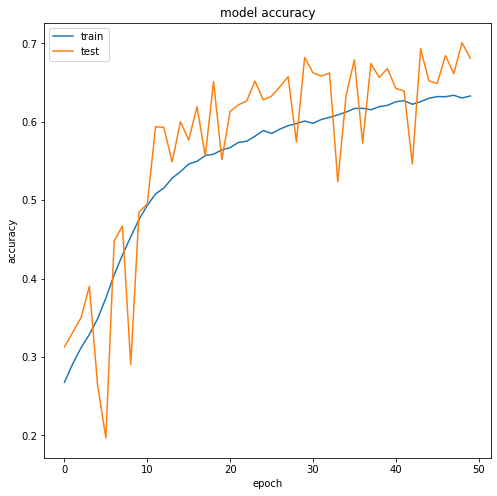

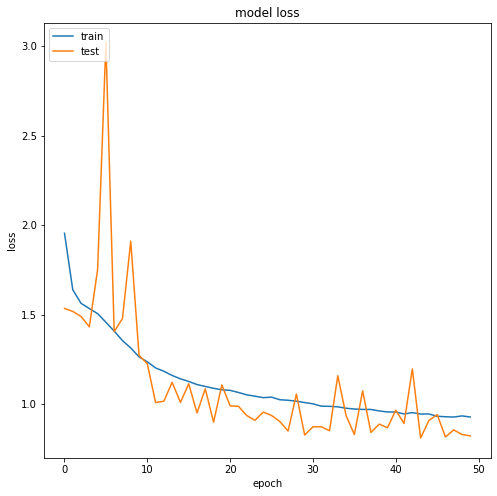

In [9]:

# summarize history for accuracy
fig = plt.figure(figsize = (8,8))
plt.plot(history_adam.history['accuracy'])
plt.plot(history_adam.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig.savefig('resnet_adam_acc_graph.jpeg')
# summarize history for loss
fig = plt.figure(figsize = (8,8))
plt.plot(history_adam.history['loss'])
plt.plot(history_adam.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig.savefig('resnet_adam_loss_graph.jpeg')

In [10]:
import pickle

In [12]:
filehandler = open('history_adam', 'wb')
pickle.dump(history_adam.history, filehandler)

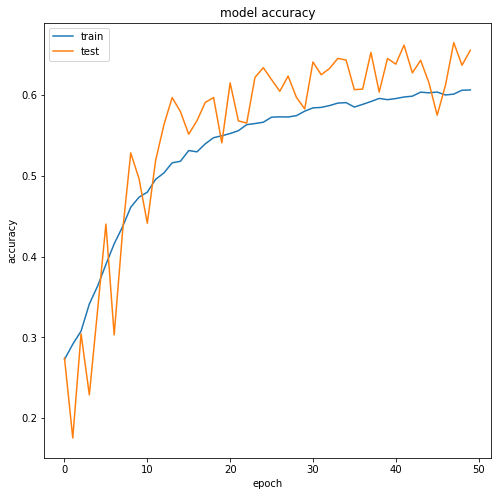

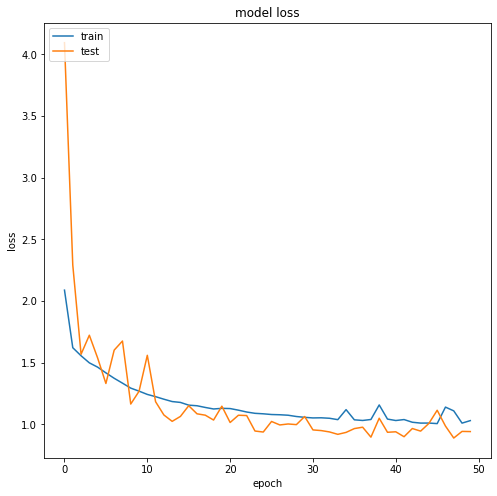

In [14]:

# summarize history for accuracy
fig = plt.figure(figsize = (8,8))
plt.plot(history_rmsprop.history['accuracy'])
plt.plot(history_rmsprop.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig.savefig('resnet_rms_acc_graph.jpeg')
# summarize history for loss
fig = plt.figure(figsize = (8,8))
plt.plot(history_rmsprop.history['loss'])
plt.plot(history_rmsprop.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig.savefig('resnet_rms_loss_graph.jpeg')

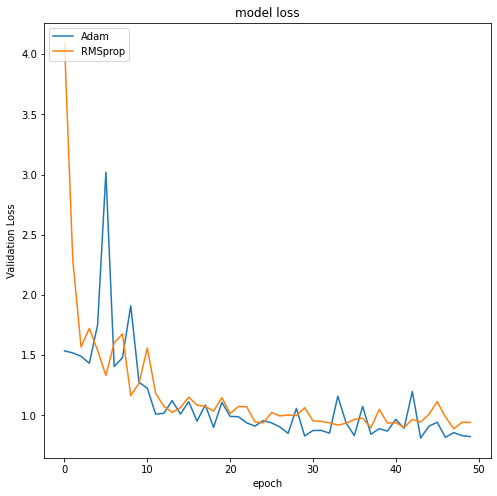

In [21]:
fig = plt.figure(figsize = (8,8))
plt.plot(history_adam.history['val_loss'])
plt.plot(history_rmsprop.history['val_loss'])
plt.title('model loss')
plt.ylabel('Validation Loss')
plt.xlabel('epoch')
plt.legend(['Adam', 'RMSprop'], loc='upper left')
plt.show()
fig.savefig('resnet_comp_acc_graph.jpeg')

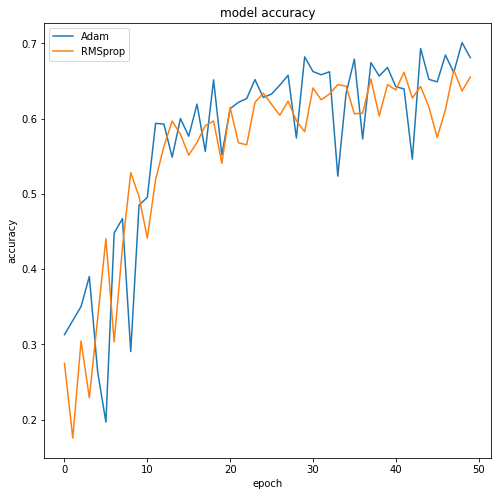

In [22]:
fig = plt.figure(figsize = (8,8))
plt.plot(history_adam.history['val_accuracy'])
plt.plot(history_rmsprop.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Adam', 'RMSprop'], loc='upper left')
plt.show()
fig.savefig('resnet_comp_loss_graph.jpeg')